In [422]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from ipywidgets import interact
from sklearn.metrics import mean_squared_error as mse

In [423]:
def lire_alpha_digit(digits, chars):
    """
    Takes as input alpha_digits and an array 'chars' containing the letters or integers to select from the alpha_digits
    """
    indexes = []
    for chr in chars:
        # check if positive integer
        if (chr.isdigit() and int(chr)<10 and int(chr)>0):
            indexes.append(int(chr))
        # check if letter
        elif(chr.isalpha() and len(chr)==1):
            indexes.append(ord(chr.lower()) - 87)
    return digits[indexes, :]

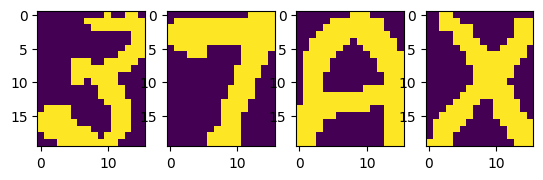

In [424]:
digits = scipy.io.loadmat('binaryalphadigs.mat')['dat']

selected_digits = lire_alpha_digit(digits, ['3', '7', 'A', '-5', 'cb', 'X']) # -5 and 'cb' won't be taken into consideration

fig, axs = plt.subplots(1, selected_digits.shape[0])
for char in range(selected_digits.shape[0]):
    axs[char].imshow(selected_digits[char][7])

A file named 'MNIST' in the same directory should contain the training and testing files extracted, and renamed by replacing the '.' to a '-' <br>
(ex: t10k-images.idx3-ubyte -> t10k-images-idx3-ubyte)

In [425]:
mndata = MNIST('MNIST')
X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], 28, 28)
y_train = np.array(y_train)

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], 28, 28)
y_test = np.array(y_test)

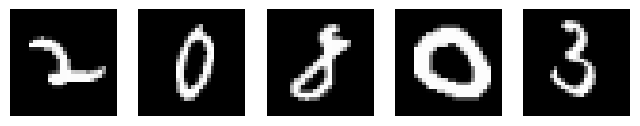

In [426]:
randoms = np.random.randint(0, X_train.shape[0], 5)

fig, axs = plt.subplots(1, randoms.shape[0], figsize=(8,8))
for char, ind in enumerate(randoms):
    axs[char].axis('off')
    axs[char].imshow(X_train[ind], cmap='gray')

In [427]:
def black_white(X, threshold = 125):
    """
    Convert grayscale images of input X to black-and-white images based on given threshold.
    """
    XX = np.empty_like(X)
    XX[X< threshold] = 0
    XX[X>=threshold] = 1
    XX = XX.reshape(*XX.shape, 1) 
    return XX

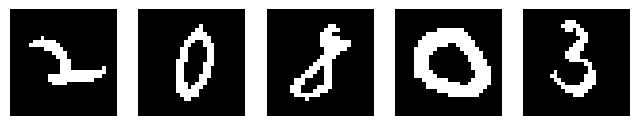

In [428]:
#Testing black_white function
X_train_new = black_white(X_train)

fig, axs = plt.subplots(1, randoms.shape[0], figsize=(8,8))
for char, ind in enumerate(randoms):
    axs[char].axis('off')
    axs[char].imshow(X_train_new[ind], cmap='gray')

In [429]:
def sigmoid(x):
    return 1/(1+np.exp(x))

class RBM:
    def __init__(self, in_shape, out_shape, W=None, a=None, b=None, var=0.1):
        assert in_shape != 0 and out_shape != 0
        self.in_shape = in_shape
        self.out_shape = out_shape
        
        self.a = a if a is not None else np.zeros(in_shape)
        self.b = b if b is not None else np.zeros(out_shape)
        self.W = W if W is not None else np.random.normal(0, var, (in_shape, out_shape))
        assert self.W.shape == (in_shape, out_shape) and (self.a).shape[0] == in_shape and (self.b).shape[0] == out_shape
        return
    
    def entree_sortie_RBM(self, X_input):
        # print("X_input", X_input.shape)
        # print("X.W", np.dot(X_input, self.W).shape)
        # print("b", self.b.shape)
        prod = np.dot(X_input, self.W) + self.b
        # print("prod", prod.shape)
        assert prod.shape == (X_input.shape[0], self.out_shape), f"prod shape {prod.shape} != (X_input.shape[0], self.out_shape) {(X_input.shape[0], self.out_shape)}"
        sig = sigmoid(prod)
        return sig, np.random.binomial(1, sig, prod.shape)
    
    def sortie_entree_RBM(self, X_output):
        prod = np.dot(X_output, self.W.T) + self.a
        assert prod.shape == (X_output.shape[0], self.in_shape)
        sig = sigmoid(prod)
        return sig, np.random.binomial(1, sig, prod.shape)
    
    def train_RBM(self, X_input, epochs=10, learning_rate=0.1, batch_size=1, vis = False):
        errors = []
        for i in range(epochs):
            final=False
            for bat in range(0, X_input.shape[0], batch_size):
                if((bat+batch_size) >= X_input.shape[0]):
                    final = True
                    v_0 = X_input[bat:]
                else:
                    v_0 = X_input[bat:bat+batch_size]
                # print("v0", v_0.shape)
                h_0p, h_0d = self.entree_sortie_RBM(v_0)
                # print("h0_p", h_0p.shape)
                v_1p, v_1d = self.sortie_entree_RBM(h_0d)
                # print("v1_p", v_1p.shape)
                h_1p, h_1d = self.entree_sortie_RBM(v_1d)
                # print("h_1p", h_1p.shape)
                # print("mult", np.outer(v_0,h_0p).shape)
                # print("mult2", np.tensordot(v_0, h_0p, axes=((0),(0))).shape)
                # print("Old W", self.W)
                self.W = self.W + learning_rate * (np.tensordot(v_0, h_0p, axes=((0),(0))) - np.tensordot(v_1p, h_1p, axes=((0),(0))))
                # print("New W", self.W)
                self.a = self.a + learning_rate * np.sum(v_0 - v_1p, 0)
                # print("h_0p-h_1p", np.sum(h_0p - h_1p, 0).shape)
                # print("before", self.b.shape)
                self.b = self.b + learning_rate * np.sum(h_0p - h_1p, 0)
                # print("after", self.b.shape)
                if (final):
                    err = mse(v_0, v_1d)
                    errors.append(err)
                    if (vis):
                        print(f"Epoch {i} mse:{err}")
        return errors
            

In [430]:
testing_rbm = RBM(8, 4)
print("RBM shape:", testing_rbm.W.shape)

# Testing entree_sortie_RBM
in_try = np.random.randint(low=0, high=2, size = (6,8))
print("\nInput shape:", in_try.shape)
print("After Entree_sortie:", testing_rbm.entree_sortie_RBM(in_try)[1].shape)

# Testing sortie_entree_RBM
out_try = np.random.randint(low=0, high=255, size = (13,4))
print("\nInput shape to hidden layer:", out_try.shape)
print("After Sortie_Entree", testing_rbm.sortie_entree_RBM(out_try)[1].shape)


RBM shape: (8, 4)

Input shape: (6, 8)
After Entree_sortie: (6, 4)

Input shape to hidden layer: (13, 4)
After Sortie_Entree (13, 8)


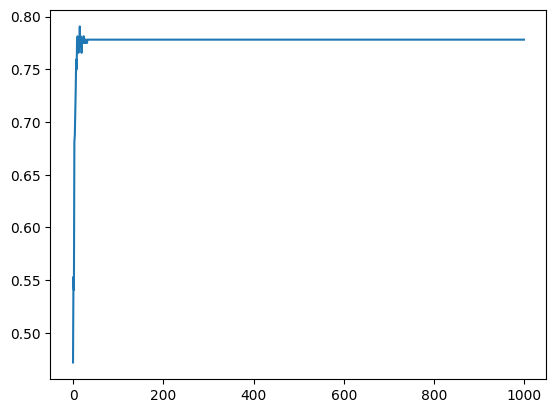

In [431]:
img_RBM = RBM(320, 250)
plt.plot(img_RBM.train_RBM(selected_digits[0][0].flatten().reshape(1, -1), 1000, 0.01))